In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [65]:
def generate_dataset(size):
    centers = [[-3, 3], [-3, -3], [3, -3], [3, 3]]
    X, _ = make_blobs(n_samples = size, centers = centers, n_features = 2, random_state = 42, cluster_std = 2)
    X = torch.FloatTensor(X)
    y = (X[:, 0] > 0) ^ (X[:, 1] > 0)
    return X, y.float().view(-1, 1)

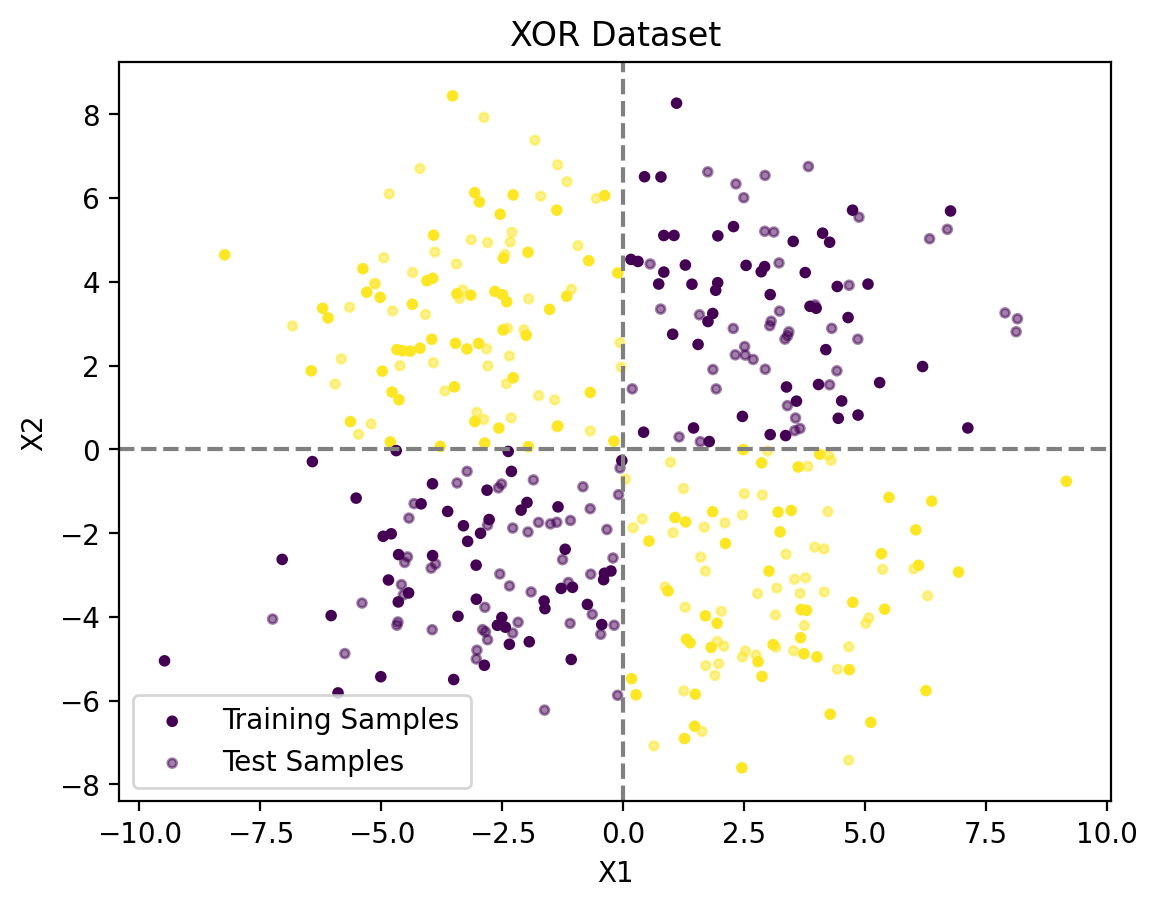

In [72]:
X, y = generate_dataset(400)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = "viridis", s = 10, label = "Training Samples")
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = "viridis", s = 10, label = "Test Samples", alpha = 0.5)
plt.xlabel("X1")
plt.ylabel("X2")
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.title("XOR Dataset")
plt.legend()
plt.show()


In [73]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([200, 2]),
 torch.Size([200, 2]),
 torch.Size([200, 1]),
 torch.Size([200, 1]))

## MLP

In [74]:
class MLP(nn.Module):
  def __init__(self, hidden_1, hidden_2):
    super().__init__()
    self.lin1 = nn.Linear(2, hidden_1)
    self.lin2 = nn.Linear(hidden_1, hidden_2)
    self.lin3 = nn.Linear(hidden_2, 1)

  def forward(self, x):
    x = torch.relu(self.lin1(x))
    x = torch.relu(self.lin2(x))
    logits = self.lin3(x)

    return logits

In [75]:
model = MLP(hidden_1 = 10, hidden_2 = 8)

In [76]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

lin1.weight torch.Size([10, 2])
lin1.bias torch.Size([10])
lin2.weight torch.Size([8, 10])
lin2.bias torch.Size([8])
lin3.weight torch.Size([1, 8])
lin3.bias torch.Size([1])


## Model Training w/ No Regularization


In [77]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)

for epoch in range(1000):
    avg_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
    
    epoch_loss = avg_loss / len(train_loader)
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}:  Loss: {epoch_loss}")

Epoch 100:  Loss: 0.019751848919051036
Epoch 200:  Loss: 0.008683788546509927
Epoch 300:  Loss: 0.002630362755943315
Epoch 400:  Loss: 0.0035067143451539906
Epoch 500:  Loss: 0.0013051662099314854
Epoch 600:  Loss: 0.0005736624722127358
Epoch 700:  Loss: 0.00035019618072900744
Epoch 800:  Loss: 0.0005234243534297482
Epoch 900:  Loss: 0.00027392910940144647
Epoch 1000:  Loss: 0.00023134118677197485


In [78]:
model.eval()

with torch.no_grad():
    logits = model(X_test)
    predictions = (logits > 0).float()
    accuracy = (predictions == y_test).sum().item() / y_test.size(0)
    print(f"Test Accuracy: {accuracy:.7f}")

Test Accuracy: 0.9900000


In [101]:
def plot_decision_boundary(X_train, X_test, y_train, y_test, model, title):
    # Combine train and test data
    X = torch.cat([X_train, X_test], dim=0).numpy()
    y = torch.cat([y_train, y_test], dim=0).numpy()

    # Determine plot range with padding
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Generate meshgrid for decision boundary
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200)
    )
    
    # Model predictions on the grid
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    Z = (Z > 0).float().numpy().reshape(xx.shape)

    # Plot decision boundary with new color palette and transparency
    plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.5)

    # Scatter plot for train and test points with different sizes and transparency
    plt.scatter(
        X_train[:, 0], X_train[:, 1], c=y_train, cmap="plasma", s=20, edgecolor="k"
    )
    plt.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap="plasma", s=30, alpha=0.5, edgecolor="k"
    )

    # Adjust legend with new labels and place it outside the plot
    patches = [
        mpatches.Patch(color="red", label="Class A"),
        mpatches.Patch(color="navy", label="Class B"),
        mpatches.Patch(color="pink", label="Predicted A"),
        mpatches.Patch(color="lightblue", label="Predicted B"),
    ]
    plt.legend(
        handles=patches, loc="lower center", bbox_to_anchor=(0.5, -0.2),
        ncol=4, fancybox=True, shadow=True
    )

    # Customize title and labels
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Feature 1", fontsize=12)
    plt.ylabel("Feature 2", fontsize=12)

    # Add gridlines for better visualization
    plt.grid(True, linestyle="--", alpha=0.7)
    
    plt.show()


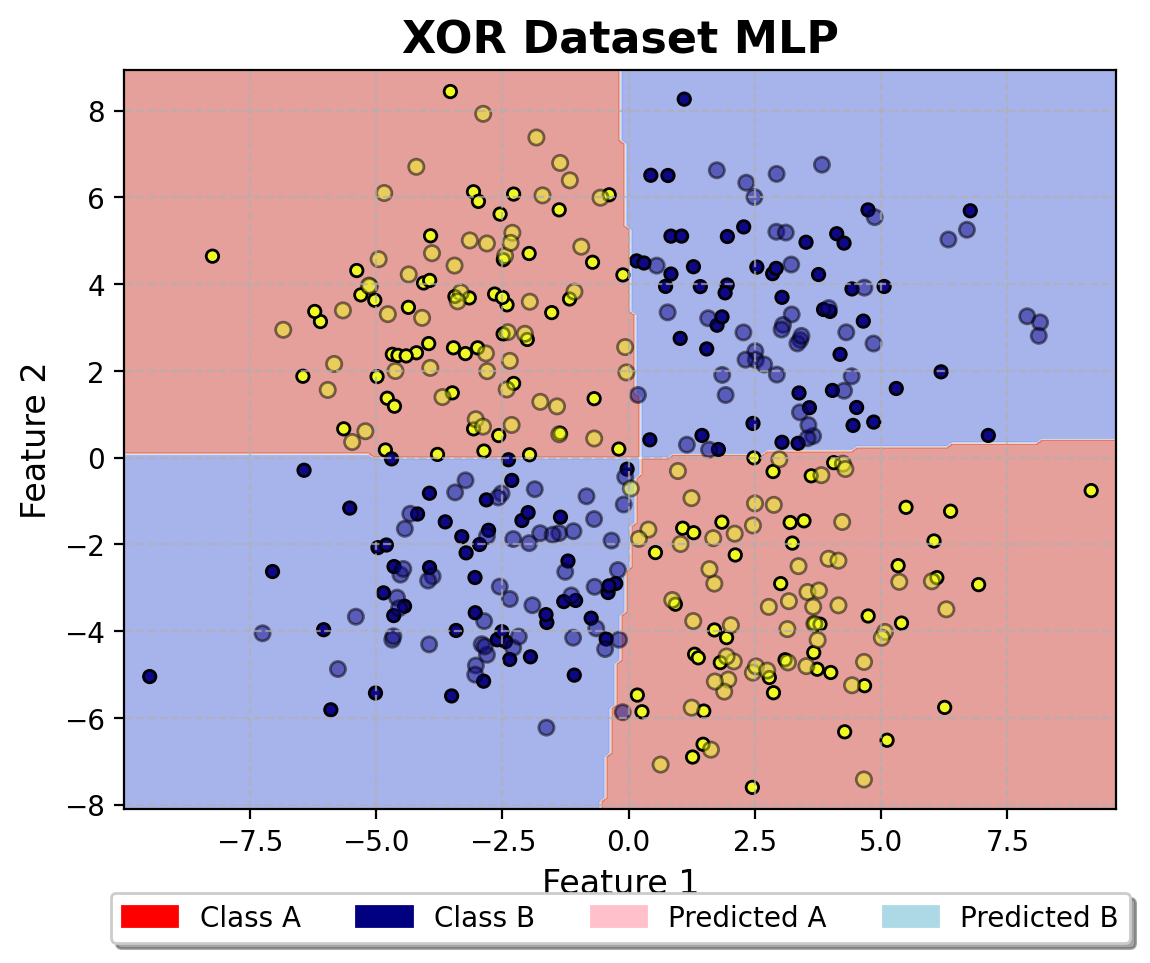

In [82]:

plot_decision_boundary(X_train, X_test, y_train, y_test, model, "XOR Dataset MLP")

## MLP w/ L1 regularization

In [96]:
model = MLP(hidden_layer1 = 10, hidden_layer2 = 8)

In [97]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

lin1.weight torch.Size([10, 2])
lin1.bias torch.Size([10])
lin2.weight torch.Size([8, 10])
lin2.bias torch.Size([8])
lin3.weight torch.Size([1, 8])
lin3.bias torch.Size([1])


## MLP w/ L1 regularization

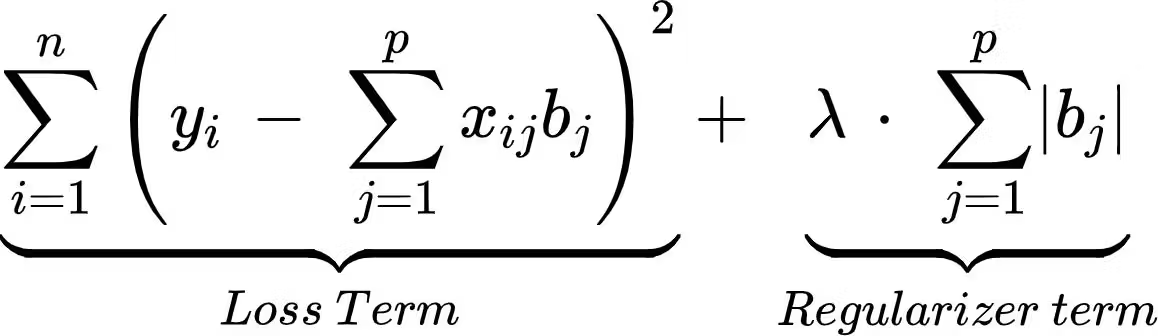


In [98]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

# L1 Regularization Penalty Coefficient
beta = 0.002

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)

for epoch in range(1000):
    avg_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        
        l1_addition = 0.0
        for param in model.parameters():
            l1_addition += torch.norm(param, 1)
        loss += beta * l1_addition
        
        
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
    
    epoch_loss = avg_loss / len(train_loader)
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}: Loss: {epoch_loss}")

Epoch 100: Loss: 0.08694873750209808
Epoch 200: Loss: 0.06893834844231606
Epoch 300: Loss: 0.06746565710221018
Epoch 400: Loss: 0.06182331006441798
Epoch 500: Loss: 0.057913502412182946
Epoch 600: Loss: 0.055011876459632604
Epoch 700: Loss: 0.10489076588835035
Epoch 800: Loss: 0.05181890247123582
Epoch 900: Loss: 0.05275217656578336
Epoch 1000: Loss: 0.051711111196449826


In [99]:
model.eval()

with torch.no_grad():
    logits = model(X_test)
    predictions = (logits > 0).float()
    accuracy = (predictions == y_test).sum().item() / y_test.size(0)
    print(f"Test Accuracy: {accuracy:.7f}")

Test Accuracy: 0.9900000


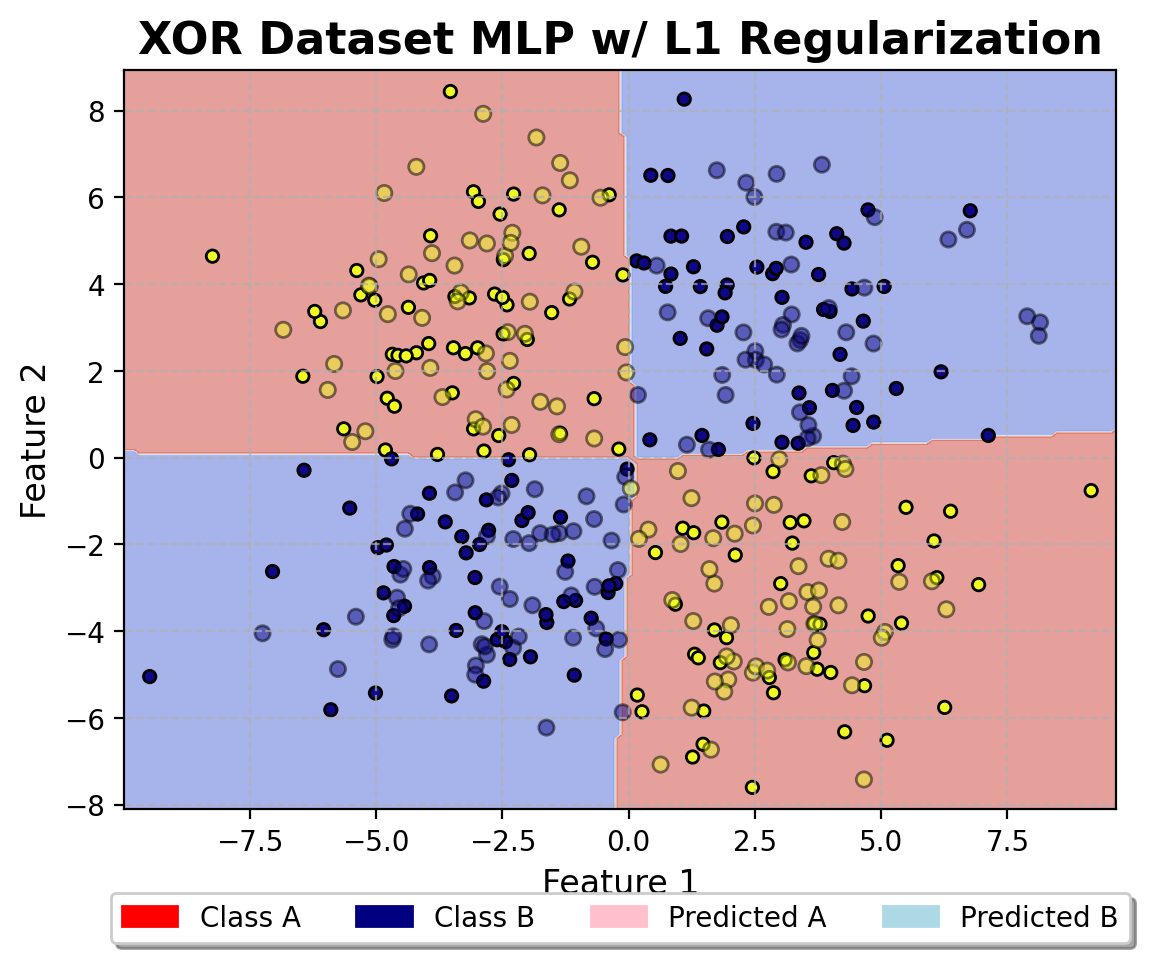

In [102]:
plot_decision_boundary(X_train, X_test, y_train, y_test, model, "XOR Dataset MLP w/ L1 Regularization")

## MLP w/ L2 regularization

In [104]:
model = MLP(hidden_layer1 = 10, hidden_layer2 = 8)

In [105]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

lin1.weight torch.Size([10, 2])
lin1.bias torch.Size([10])
lin2.weight torch.Size([8, 10])
lin2.bias torch.Size([8])
lin3.weight torch.Size([1, 8])
lin3.bias torch.Size([1])


## Model Training w/ $L_2$ Regularization
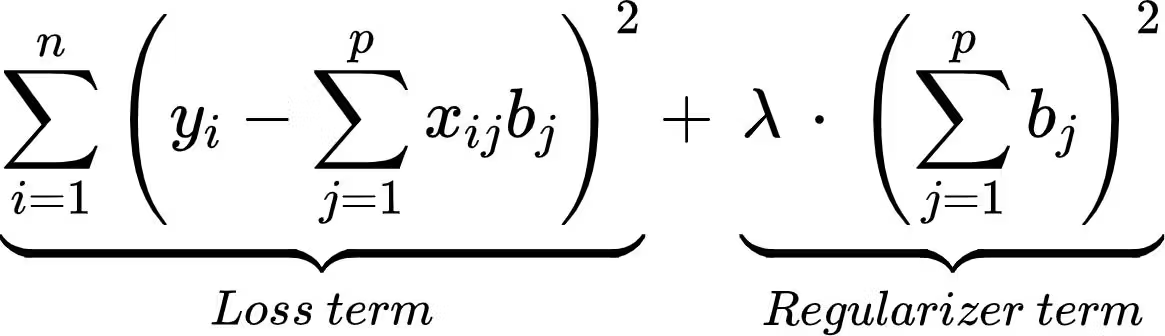

In [106]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

# L2 Regularization Penalty Coefficient
beta = 0.002

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)

for epoch in range(1000):
    avg_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        
        l2_addition = 0.0
        for param in model.parameters():
            l2_addition += torch.norm(param, 2)
        loss += beta * l2_addition
        
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
    
    epoch_loss = avg_loss / len(train_loader)
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}: Loss: {epoch_loss} ")

Epoch 100: Loss: 0.03870204383773463 
Epoch 200: Loss: 0.026116428630692617 
Epoch 300: Loss: 0.02194508644086974 
Epoch 400: Loss: 0.024184494146278927 
Epoch 500: Loss: 0.018287089919405326 
Epoch 600: Loss: 0.017630183404045447 
Epoch 700: Loss: 0.018596242048910687 
Epoch 800: Loss: 0.017611379868217876 
Epoch 900: Loss: 0.01734719771359648 
Epoch 1000: Loss: 0.017316731225167 


In [107]:
model.eval()

with torch.no_grad():
    logits = model(X_test)
    predictions = (logits > 0).float()
    accuracy = (predictions == y_test).sum().item() / y_test.size(0)
    print(f"Test Accuracy: {accuracy:.7f}")

Test Accuracy: 0.9950000


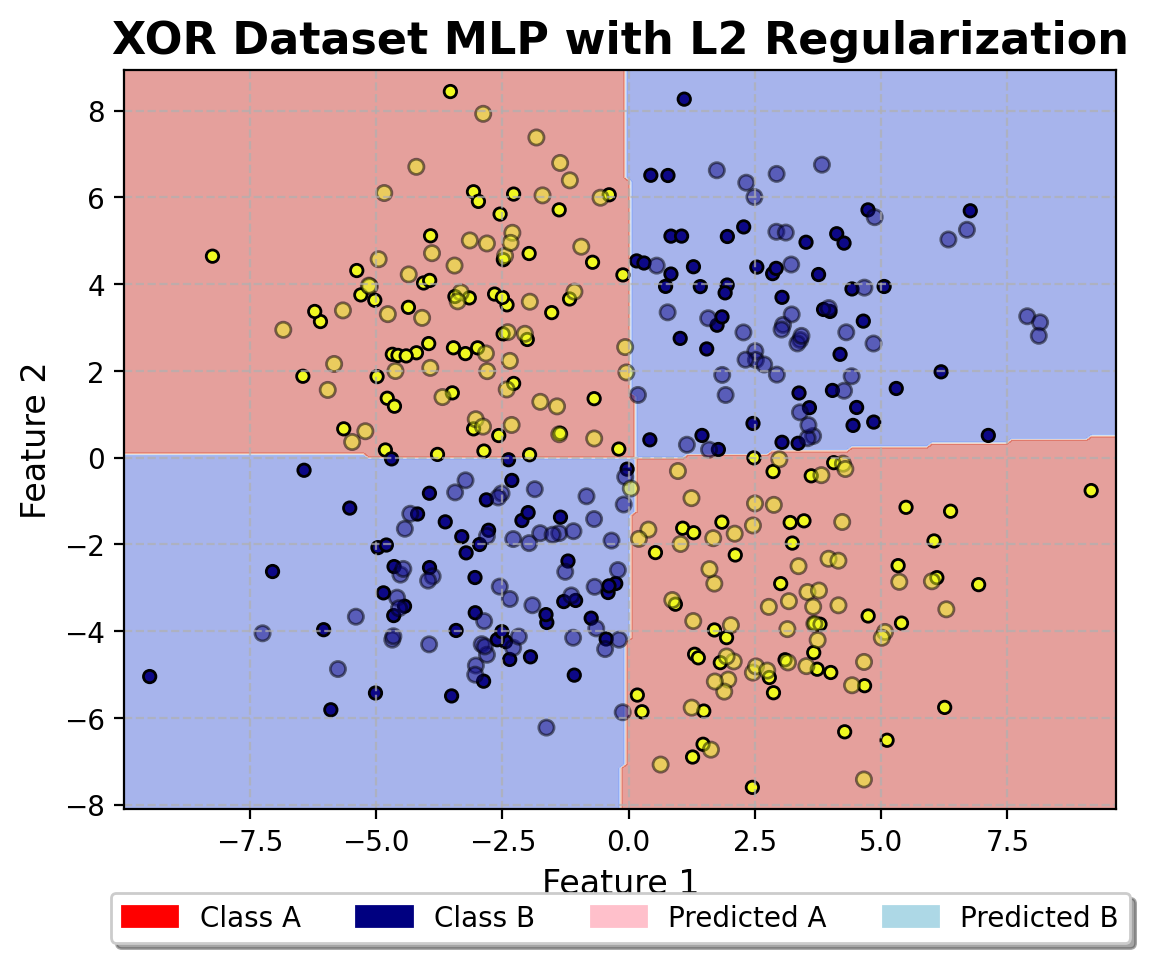

In [108]:
plot_decision_boundary(X_train, X_test, y_train, y_test, model, r"XOR Dataset MLP with L2 Regularization")

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

poly = PolynomialFeatures(degree = 2, include_bias = False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LogisticRegression()
model.fit(X_train_poly, y_train.ravel())

y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

Train Accuracy:  0.995
Test Accuracy:  0.995


In [110]:
def plot_decision_boundary(X_train, X_test, y_train, y_test, model, title):
    # Concatenate train and test data
    X = np.concatenate([X_train, X_test], axis=0)
    y = np.concatenate([y_train, y_test], axis=0)

    # Determine plot boundaries with small padding
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Create meshgrid for plotting the decision boundary
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # Transform meshgrid data with polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    meshgrid_poly = poly.fit_transform(np.c_[xx.ravel(), yy.ravel()])

    # Predict on the meshgrid data
    Z = model.predict(meshgrid_poly)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary using contour plot with new color scheme
    plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.6)

    # Scatter plot for train and test data with new sizes and edgecolors
    plt.scatter(
        X_train[:, 0], X_train[:, 1], c=y_train, cmap="magma", s=25, edgecolor="black", linewidth=0.5
    )
    plt.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap="magma", s=30, alpha=0.7, edgecolor="black", linewidth=0.5
    )

    # Update legend with new colors and labels
    patches = [
        mpatches.Patch(color="red", label="Class A"),
        mpatches.Patch(color="navy", label="Class B"),
        mpatches.Patch(color="lightcoral", label="Predicted A"),
        mpatches.Patch(color="skyblue", label="Predicted B"),
    ]
    plt.legend(
        handles=patches, loc="lower right", fancybox=True, shadow=True, frameon=True
    )

    # Customize title and axis labels
    plt.title(title, fontsize=14, fontweight="bold", pad=10)
    plt.xlabel("X1", fontsize=12)
    plt.ylabel("X2", fontsize=12)

    # Add a grid for better visual separation
    plt.grid(visible=True, linestyle="--", alpha=0.7)

    # Display the plot
    plt.show()


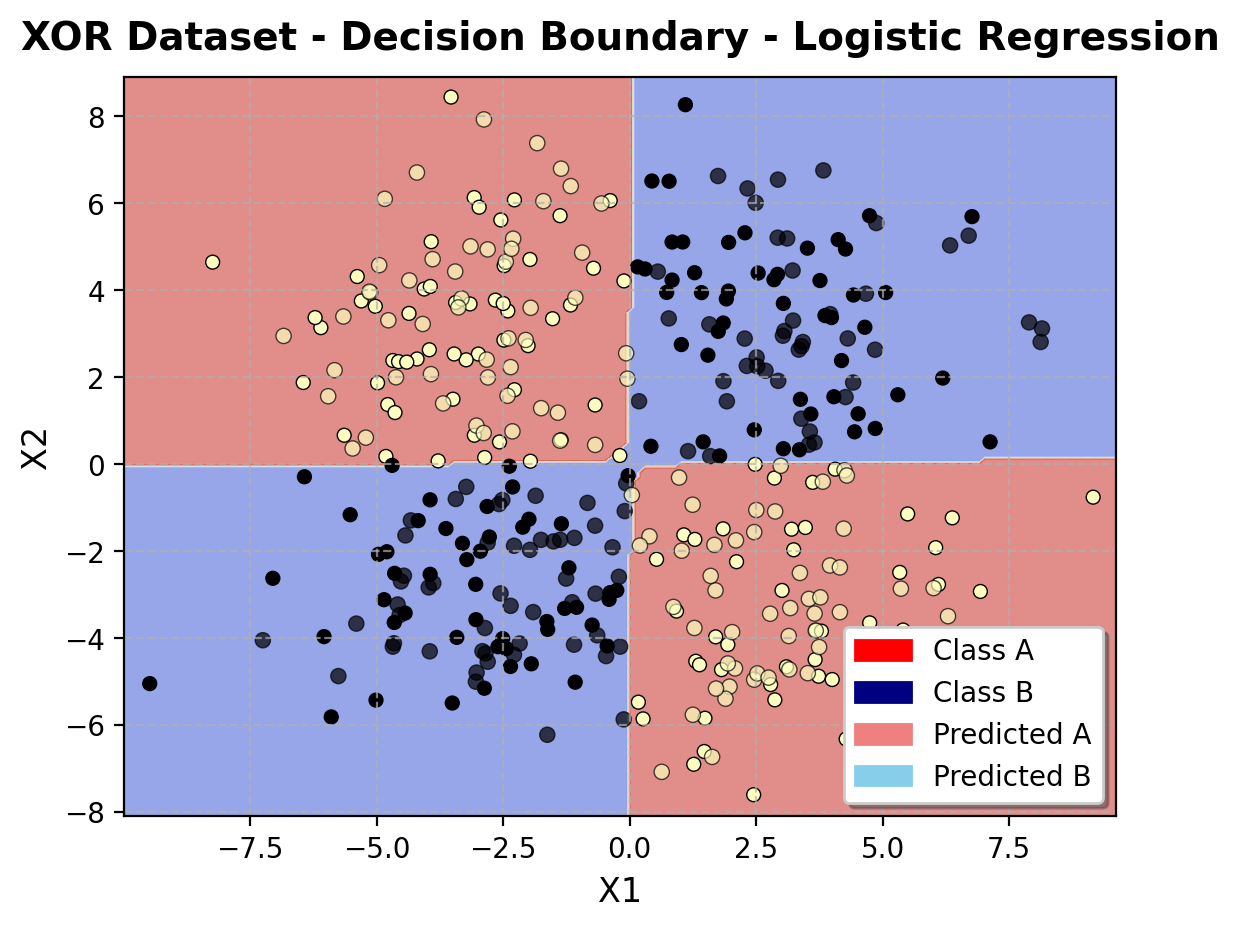

In [111]:
plot_decision_boundary(X_train_poly, X_test_poly, y_train, y_test, model, "XOR Dataset - Decision Boundary - Logistic Regression")

The logistic regression model learns the graph at a slow rate cause it has limited features which are provided by the user whereas the MLP choses the features by itself which helps the model to learn the dataset more precisely.